In [1]:
import pdb
import traceback

import jax
from jax import jit
from jax import numpy as jnp
import optax
import wandb
import equinox as eqx
from inr_utils.images import make_lin_grid


from common_dl_utils.config_creation import Config
import common_jax_utils as cju
import neural_tangents as nt
wandb.login()

key = jax.random.PRNGKey(12398)
key_gen = cju.key_generator(key)

2025-01-07 16:22:09.738331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736263329.754040    7776 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736263329.758538    7776 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: maxwell_litsios (bep-circle). Use `wandb login --relogin` to force relogin


In [2]:
config = Config()

# first we specify what the model should look like
config.architecture = './model_components'  # module containing all relevant classes for architectures
# NB if the classes relevant for creating the model are spread over multiple modules, this is no problem
# let config.architecture be the module that contains the "main" model class, and for all other components just specify the module
# or specify the other modules as default modules to the tools in common_jax_utils.run_utils
config.model_type = 'inr_modules.CombinedINR'

config.model_config = Config()
config.model_config.in_size = 2
config.model_config.out_size = 2
config.model_config.terms = [  # CombinedINR uses multiple MLPs and returns the sum of their outputs. These 'terms' are the MLPs
    ('inr_modules.MLPINR.from_config',{
        'hidden_size': 1028,
        'num_layers': 3,
        # 'layer_type': 'inr_layers.GaussianINRLayer',
        # 'layer_type': 'inr_layers.SirenLayer',
        'layer_type': 'inr_layers.ComplexWIRE',
        'num_splits': 1,
        'activation_kwargs': {'w0': 25., "s0":15},
        # 'activation_kwargs': {'w0': 25.},
        # 'activation_kwargs': {'inverse_scale': 1},
        'initialization_scheme':'initialization_schemes.siren_scheme',
        'initialization_scheme_kwargs': {'w0': 12.},
        'post_processor':'auxiliary.real_scalar'
        
        # 'positional_encoding_layer': ('inr_layers.ClassicalPositionalEncoding.from_config', {'num_frequencies': 10}),
    }),
    # ('inr_modules.MLPINR.from_config',{
    #     'hidden_size': 1024,
    #     'num_layers': 2,
    #     'num_splits': 1,
    #     'layer_type': 'inr_layers.GaussianINRLayer',
    #     'use_complex': False,
    #     'activation_kwargs': {'inverse_scale': 1},
    # })
]

In [3]:
def apply_inr(inr, location):
    return inr(location)

inr_grad = eqx.filter_grad(apply_inr)

In [4]:
def prep_x_ys(n = 10):

    locations = make_lin_grid(0., 1., (n, n))
    location_dims = locations.shape
    in_channels = location_dims[-1]
    out_channels = 2
    flattened_locations = locations.reshape(-1, in_channels)
    #rgb_vals = random.uniform(next(key_gen), (flattened_locations.shape[0], out_channels), minval=0, maxval=1)
    rgb_vals = jnp.sin(2*jnp.pi* flattened_locations)


    return flattened_locations, in_channels, rgb_vals, out_channels


flatten_locs, in_channels, _, _ = prep_x_ys(10)



In [5]:

def make_mlp():
    try:
        inr = cju.run_utils.get_model_from_config_and_key(
            prng_key=next(key_gen),
            config=config,
            model_sub_config_name_base='model',
            add_model_module_to_architecture_default_module=False, # since the model is already in the default module specified by 'architecture',
        )
    except Exception as e:
        traceback.print_exc()
        print(e)
        print('\n')
        pdb.post_mortem()
        

    params, static = eqx.partition(inr, eqx.is_inexact_array)

    def init_fn():
        return params

    def apply_fn(_params, x):
        model = eqx.combine(_params, static)
        return model(x)

    return init_fn, jax.vmap(apply_fn, (None, 0))

init_fn, apply_fn = make_mlp()




In [6]:
kwargs = dict(
        f=apply_fn,
        trace_axes=(),
        vmap_axes=0
    )
jacobian_contraction = jit(nt.empirical_ntk_fn(**kwargs, implementation=nt.NtkImplementation.JACOBIAN_CONTRACTION))
ntvp = jit(nt.empirical_ntk_fn(**kwargs, implementation=nt.NtkImplementation.NTK_VECTOR_PRODUCTS))
auto = jit(nt.empirical_ntk_fn(**kwargs, implementation=nt.NtkImplementation.AUTO))

In [7]:
params = init_fn()
params


CombinedINR(
  terms=(
    MLPINR(
      layers=(
        ComplexWIRE(
          weights=f32[1028,2],
          biases=f32[1028],
          activation_kwargs={'s0': 15, 'w0': 25.0}
        ),
        ComplexWIRE(
          weights=f32[1028,1028],
          biases=f32[1028],
          activation_kwargs={'s0': 15, 'w0': 25.0}
        ),
        Linear(weights=f32[2,1028], biases=f32[2], activation_kwargs={}),
        Lambda(fn=None)
      )
    ),
  ),
  post_processor=None
)

In [8]:
    

k_1 = jacobian_contraction(flatten_locs, flatten_locs, params)

/home/ovindar/PycharmProjects/INR_BEP/.venv/lib/python3.10/site-packages/jax/_src/lax/lax.py:3458: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


In [9]:
k_2 = ntvp(flatten_locs, flatten_locs, params)


/home/ovindar/PycharmProjects/INR_BEP/.venv/lib/python3.10/site-packages/jax/_src/lax/lax.py:3458: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


In [10]:
k_2

Array([[2.0270326, 1.9320865, 1.6890305, ..., 1.7334601, 1.7222036,
        1.8918443],
       [1.9320865, 1.928046 , 1.6543725, ..., 1.6942558, 1.687427 ,
        1.8387806],
       [1.6890305, 1.6543725, 1.5846901, ..., 1.5620272, 1.5624385,
        1.7006903],
       ...,
       [1.7334601, 1.6942558, 1.5620272, ..., 1.6904728, 1.6146166,
        1.6987569],
       [1.7222036, 1.687427 , 1.5624385, ..., 1.6146166, 1.6599615,
        1.7606647],
       [1.8918443, 1.8387806, 1.7006903, ..., 1.6987569, 1.7606647,
        2.0083747]], dtype=float32)

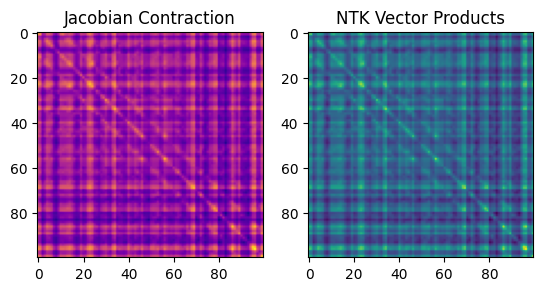

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

ax[0].imshow(k_1, cmap="plasma")
ax[0].set_title('Jacobian Contraction')
ax[1].imshow(k_2)
ax[1].set_title('NTK Vector Products')



plt.show()



In [12]:
import matplotlib.pyplot as plt




In [14]:
eigvals, eigvecs = jnp.linalg.eigh(k_2)

In [15]:
rescaled_eigvals = eigvals / jnp.min(jnp.abs(eigvals))



({'bodies': [<matplotlib.collections.PolyCollection at 0x7f68b021b130>],
  'cmaxes': <matplotlib.collections.LineCollection at 0x7f68b021b070>,
  'cmins': <matplotlib.collections.LineCollection at 0x7f68b021b700>,
  'cbars': <matplotlib.collections.LineCollection at 0x7f68b021bac0>},
 None)

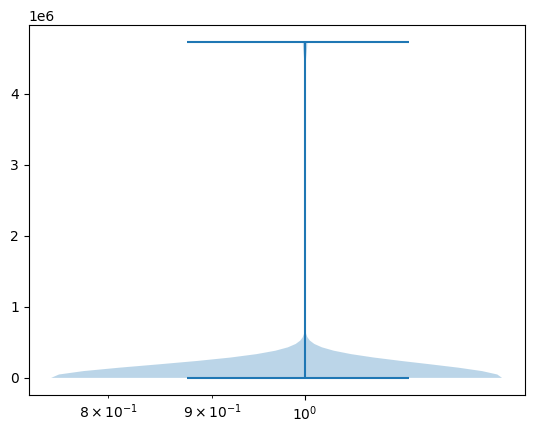

In [25]:
plt.violinplot(rescaled_eigvals), plt.xscale('log')

((array([99.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  1.]),
  array([1.00000000e+00, 2.36513625e+05, 4.73026250e+05, 7.09538875e+05,
         9.46051500e+05, 1.18256412e+06, 1.41907675e+06, 1.65558938e+06,
         1.89210200e+06, 2.12861450e+06, 2.36512725e+06, 2.60164000e+06,
         2.83815250e+06, 3.07466500e+06, 3.31117775e+06, 3.54769050e+06,
         3.78420300e+06, 4.02071550e+06, 4.25722800e+06, 4.49374100e+06,
         4.73025350e+06]),
  <BarContainer object of 20 artists>),
 None)

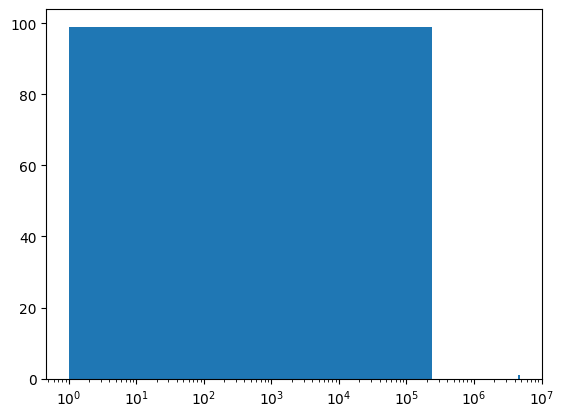

In [22]:
plt.hist(rescaled_eigvals, bins=20), plt.xscale('log')

In [17]:
eigvals

Array([3.4867437e-05, 4.5358116e-05, 4.9610921e-05, 5.4367047e-05,
       5.6941728e-05, 6.4916698e-05, 8.8535984e-05, 1.1249695e-04,
       1.3202203e-04, 1.8332123e-04, 1.8996597e-04, 2.3406728e-04,
       2.5256592e-04, 2.5627675e-04, 2.6640040e-04, 2.7224762e-04,
       3.7190464e-04, 3.9804360e-04, 3.9897644e-04, 4.9893087e-04,
       5.0367048e-04, 6.7554344e-04, 6.9079071e-04, 7.7472231e-04,
       7.8084879e-04, 8.5901673e-04, 8.7590201e-04, 8.8467880e-04,
       1.1093080e-03, 1.2198051e-03, 1.2689629e-03, 1.3591977e-03,
       1.5599126e-03, 1.6780996e-03, 1.8080648e-03, 2.0459637e-03,
       2.2661004e-03, 2.4930129e-03, 2.6440048e-03, 2.8597973e-03,
       3.0831979e-03, 3.4791632e-03, 3.6995087e-03, 4.2118733e-03,
       4.3516476e-03, 4.7842194e-03, 5.8029066e-03, 6.4934748e-03,
       6.9616390e-03, 7.6050828e-03, 8.3363373e-03, 9.4289603e-03,
       9.8887738e-03, 1.1815977e-02, 1.2462652e-02, 1.4416518e-02,
       1.5205649e-02, 1.7722055e-02, 2.2865035e-02, 2.8113844e